# pandas - Data Aggregation and Group Operations

In [92]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

## GroupBy Mechanics

The term *split-apply-combine* for describing group operations.

Steps:
1. Data is split into group based on one or more keys. (the splitting is performed on a particular axis of an object, for example a DataFrame can be grouped on its rows(axis=0) or its columns(axis=1).
2. A function will be applied to each group to produce a new value.
3. Finally, the results of those functions applications are combined into a result object.

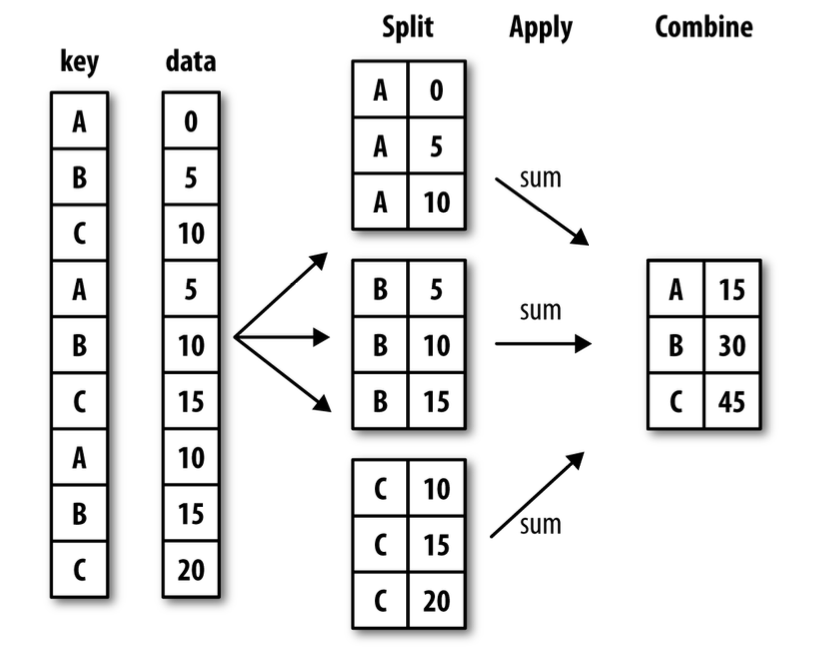

In [93]:
df = DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                'key2' : ['one', 'two', 'one', 'two', 'one'],
                'data1' : np.random.randn(5),
                'data2' : np.random.randn(5)})
df

In [94]:
# computing mean of data1 by taking key1
grouped = df['data1'].groupby(df['key1'])
grouped.mean()

In [95]:
# computing mean of data1 by taking key1 and key2
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

In [96]:
means.unstack()

In [97]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])

df['data1'].groupby([states, years]).mean() # could take any arrays of the right length

In [98]:
df.groupby('key1').mean()

In [99]:
df.groupby(['key1', 'key2']).size() # return the count of group sizes

### Iterating Over Groups

In [100]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

In [101]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

In [102]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

In [103]:
df.dtypes

In [104]:
grouped = df.groupby(df.dtypes, axis=1)

for dtype, group in grouped:
    print(dtype)
    print(group)

### Selecting a Column or Subset of Columns

`df.groupby('key1')['data1']` is syntatic sugar for `df['data1'].groupby(df['key1'])`

`df.groupby('key1')[['data2']]` is syntatic sugar for `df[['data2']].groupby(df['key1'])`

In [105]:
df.groupby(['key1', 'key2'])[['data2']].mean()

In [106]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped.mean() # same like above

### Grouping with Dicts and Series

In [107]:
people = DataFrame(np.random.randn(5, 5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [108]:
people.iloc[2:3, [1, 2]] = np.nan # add NA values
people

In [109]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

In [110]:
by_column = people.groupby(mapping, axis=1) # sum based on its columns references from mapping
by_column.sum()

In [111]:
map_series = Series(mapping)
map_series

In [112]:
people.groupby(map_series, axis=1).count() # just like above but using Series

### Grouping with Functions

In [113]:
people.groupby(len).sum() # group by the length of the names/index

In [114]:
people

In [115]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

### Grouping by Index Levels

In [116]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'], [1, 3, 5, 1, 3]], names=['cty', 'tenor'])
columns

In [117]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

In [118]:
hier_df.groupby(level='cty', axis=1).count()

## Data Aggregation

Aggregations refer to any data transformation that produces **scalar** values from arrays.

In [119]:
df

In [120]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

In [121]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

grouped.agg(peak_to_peak) # passing our own aggregation function

In [122]:
grouped.describe() # strictly speaking (aggregation but not likely)

### Column-Wise and Multiple Function Application

In [123]:
tips = pd.read_csv('../input/pandas-data-loading-storage-file-formats/tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

In [124]:
grouped = tips.groupby(['day', 'smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean') # can pass a name of function as a string

In [125]:
grouped_pct.agg(['mean', 'std', peak_to_peak]) # bunch of aggs

In [126]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)]) # apply naming conventions to mean and std

In [127]:
functions = ['count', 'mean', 'max']

result = grouped['tip_pct', 'total_bill'].agg(functions)
result

In [128]:
result['tip_pct']

In [129]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

In [130]:
grouped.agg({'tip' : np.max, 'size' : 'sum'}) # naming conventions using dict

In [131]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'], 'size' : 'sum'})

### Returning Aggregated Data Without Row Indexes

In [132]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

## Apply: General split-apply-combine

`apply` splits the object being manipulated into pieces, invokes the passed function on each piece, then attempts to concatenate the pieces together.

In [133]:
tips

In [134]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [135]:
top(tips, n=6)

In [136]:
tips.groupby('smoker').apply(top) # top is applied to each row group

In [137]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

### Suppressing the Group Keys

In [138]:
tips.groupby('smoker', group_keys=False).apply(top)

### Quantile and Bucket Analysis

In [139]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
frame

In [140]:
quartiles = pd.cut(frame.data1, 4)
quartiles.head(10)

In [141]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

In [142]:
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

In [143]:
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

### Example: Filling Missing Values with Group-Specific Values

When cleaning up missing data, in some cases you will replace data observations using dropna, but in others you may want to impute (fill in) the null (NA) values using a fixed value or some value derived from the data. `fillna` is the right tool to use...

In [144]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

In [145]:
s.fillna(s.mean())

In [146]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4

In [147]:
data = Series(np.random.randn(8), index=states)
data

In [148]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

In [149]:
data.groupby(group_key).mean()

In [150]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean) # fill NA values

In [151]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

### Example: Random Sampling and Permutation

In [152]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4 
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q'] 
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names) 
deck = pd.Series(card_val, index=cards)

In [153]:
deck[:13]

In [154]:
# drawing 5 cards
def draw(deck, n=5):
    return deck.sample(n)
draw(deck)

In [155]:
get_suit = lambda card: card[-1] # last letter is suit

deck.groupby(get_suit).apply(draw, n=2)

In [156]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2) # alternatively

### Example: Group Weighted Average and Correlation

In [157]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

In [158]:
grouped = df.groupby('category')

get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

grouped.apply(get_wavg)

In [159]:
close_px = pd.read_csv('../input/pandas-data-loading-storage-file-formats/stock_px_2.csv', parse_dates=True, index_col=0)
close_px.info()

In [160]:
close_px[-4:]

In [161]:
spx_corr = lambda x: x.corrwith(x['SPX'])

In [162]:
rets = close_px.pct_change().dropna()

In [163]:
get_year = lambda x: x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

In [164]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

### Example: Group-Wise Linear Regression

In [165]:
import statsmodels.api as sm 
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars] 
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit() 
    return result.params

In [166]:
by_year.apply(regress, 'AAPL', ['SPX'])

## Pivot Tables and Cross-Tabulation

A *pivot table* is a data summarization tool frequently found in spreadsheet programs and other data analysis software. It aggregates a table of data by one or more keys, arranging the data in a rectangle with some of the group keys along the rows and some along the columns. 

In [167]:
tips.pivot_table(index=['day', 'smoker'])

In [168]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker')

In [169]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker', margins=True)

In [170]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'], columns='day', aggfunc='mean', fill_value=0)

### Cross-Tabulations: Crosstab

A cross-tabulation (or *crosstab* for short) is a special case of a pivot table that computes group frequencies.

In [171]:
data

In [172]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

In [ ]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)